In [2]:
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [155]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import pickle
import numpy as np
import spacy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Embedding, LSTM
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
import string
from sklearn.metrics import classification_report


### set paths and read data

In [156]:
AEM = '../tmpanne/fullsample/w2v_model_nr_7_window_10_size_300_negsample_15.txt'
PATH_TO_DATA = "../tmpanne/RPA_and_Buschers_data_with_dictionaryscores.pkl"

In [157]:
df = pd.read_pickle(PATH_TO_DATA)

In [7]:
#df['topic'].to_list()

In [158]:
df['main_topic_id']  = df['main_topic_label'].factorize()[0]
len(df['main_topic_id'].unique())


19

In [159]:
def encodeY(Y):
    '''create one-hot (dummies) for output, see also https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
    encode class values as integers
    '''
    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)
    dummy_y = tf.keras.utils.to_categorical(encoded_Y)
    return dummy_y

In [160]:
x = [t.translate(str.maketrans('', '', string.punctuation)) for t in df['text_x']]
y = encodeY(df['main_topic_id'].map(int))

#y=tf.keras.utils.to_categorical(y,19)

In [161]:
X_train, X_test, y_train, y_test = train_test_split([t.translate(str.maketrans('', '', string.punctuation)) for t in df['text_x']], encodeY(df['main_topic_id'].map(int)), test_size = 0.2)

In [162]:
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(X_train)

In [163]:
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(X_train)
# pad sequences
max_length = max([len(s.split()) for s in X_train])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define training labels
#ytrain = array([0 for _ in range(900)] + [1 for _ in range(900)])


In [164]:
# HIER OVER NADENKEN
encoded_docs = tokenizer.texts_to_sequences(X_test)
# pad sequences
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [46]:
#Xtrain[0]

array(['6', '2', '12', '16', '3', '14', '20', '1', '19', '15', '5', '10',
       '00', '18', '13', '9', '4', '8', '7', '23', '17', '21', '0', '',
       99, 16, 5, 3, 20, 9, 12, 19, 10, 1, 4, 7, 15, 17, 14, 2, 6, 8, 13],
      dtype=object)

In [165]:
embeddings_index = {}
with open(AEM) as f:
    numberofwordvectors, dimensions = [int(e) for e in next(f).split()]
    for line in tqdm(f):
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
       # word = values[0]
       # coefs = np.asarray(values[1:], dtype='float32')
      #  embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))
print('Should be {} vectors with {} dimensions'.format(numberofwordvectors, dimensions))

1055100it [01:17, 13694.59it/s]

Found 1055100 word vectors.
Should be 1055100 vectors with 300 dimensions


In [ ]:
#test = [e for e in ][10]

In [ ]:
#sum([np.isnan(vector.any()) for vector in embeddings_index.values()])

In [166]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    words_not_found = 0 
    total_words = 0
    DEBUG_lijstmetwoorden = []
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 300))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in tqdm(vocab.items()):
        e = embedding.get(word, None)
        if e is not None:   # if we do not find the word, we do not want to replace anything but leave the zero's
            weight_matrix[i] = e
            total_words+=1
        else:
            words_not_found+=1
            DEBUG_lijstmetwoorden.append(word)
    print('Weight matrix created. For {} out of {} words, we did not have any embedding.'.format(words_not_found, total_words))
    return DEBUG_lijstmetwoorden, weight_matrix

In [167]:
missingwords, embedding_vectors = get_weight_matrix(embeddings_index, tokenizer.word_index)

100%|██████████| 304335/304335 [00:00<00:00, 474483.49it/s]

Weight matrix created. For 198479 out of 105856 words, we did not have any embedding.


In [168]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.85866785, -2.4100337 ,  0.33942223, ...,  2.51087785,
         1.81039345,  2.77537751],
       [ 1.21925008,  3.80267596,  1.04939997, ...,  1.60943902,
        -0.93306959,  0.42656401],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-5.63556814, -1.39371872,  2.9276433 , ..., -0.65662706,
         0.23581095,  0.05095471],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [169]:
len(embedding_vectors), len(Xtrain)

(304336, 11992)

In [170]:
embedding_layer = Embedding(len(tokenizer.word_index)+1, 300, weights=[embedding_vectors], input_length=max_length, trainable=False)

In [28]:
# define model
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3763, 300)         448422300 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3759, 128)         192128    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1879, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 240512)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 962052    
Total params: 449,576,480
Trainable params: 1,154,180
Non-trainable params: 448,422,300
_________________________________________________________________
None


In [171]:
# THIS ONE!

from tensorflow.keras.metrics import Recall

numberoflabels = len(df['main_topic_id'].unique())

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(128, 4, activation='relu'))
model.add(MaxPooling1D(4))
model.add(MaxPooling1D(4))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=numberoflabels, activation='softmax'))   # voor twee categorien sigmoid, voor 1 tanh
 
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3899, 300)         91300800  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3896, 128)         153728    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 974, 128)          0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 243, 128)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 31104)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1990720   
_________________________________________________________________
dense_7 (Dense)              (None, 19)               

In [172]:

from tensorflow.python.keras.callbacks import Callback

class Metrics(Callback):
    def __init__(self, x, y):
        self.x = x
        self.y = y if (y.ndim == 1 or y.shape[1] == 1) else np.argmax(y, axis=1)
        self.reports = []

    def on_epoch_end(self, epoch, logs={}):
        y_hat = np.asarray(self.model.predict(self.x))
        y_hat = np.where(y_hat > 0.5, 1, 0) if (y.ndim == 1 or y_hat.shape[1] == 1)  else np.argmax(y_hat, axis=1)
        report = classification_report(self.y,y_hat,output_dict=True)
        self.reports.append(report)
        return

    # Utility method
    def get(self, metrics, of_class):
        return [report[str(of_class)][metrics] for report in self.reports]

metrics_milticlass = Metrics(Xtrain, y_train)
#milticlass_model.fit(x, y, epochs=30, callbacks=[metrics_milticlass])


In [ ]:

model.fit(Xtrain, y_train, epochs=40, validation_data=[Xtest, y_test], 
       verbose=True, callbacks=[metrics_milticlass])

Train on 11992 samples, validate on 2999 samples
Epoch 1/40
11992/11992 [==============================] - 228s 19ms/sample - loss: 2.4639 - acc: 0.3285 - val_loss: 2.1270 - val_acc: 0.3434


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 2/40
11992/11992 [==============================] - 227s 19ms/sample - loss: 1.9690 - acc: 0.3580 - val_loss: 1.9502 - val_acc: 0.3778
Epoch 3/40
 4512/11992 [==========>...................] - ETA: 1:38 - loss: 1.8226 - acc: 0.4147

In [122]:
# df[['main_topic_id', 'main_topic_label']].sort_values('main_topic_id')
labels = df.groupby('main_topic_id')['main_topic_label'] .max()

In [128]:
labels = labels.to_list()

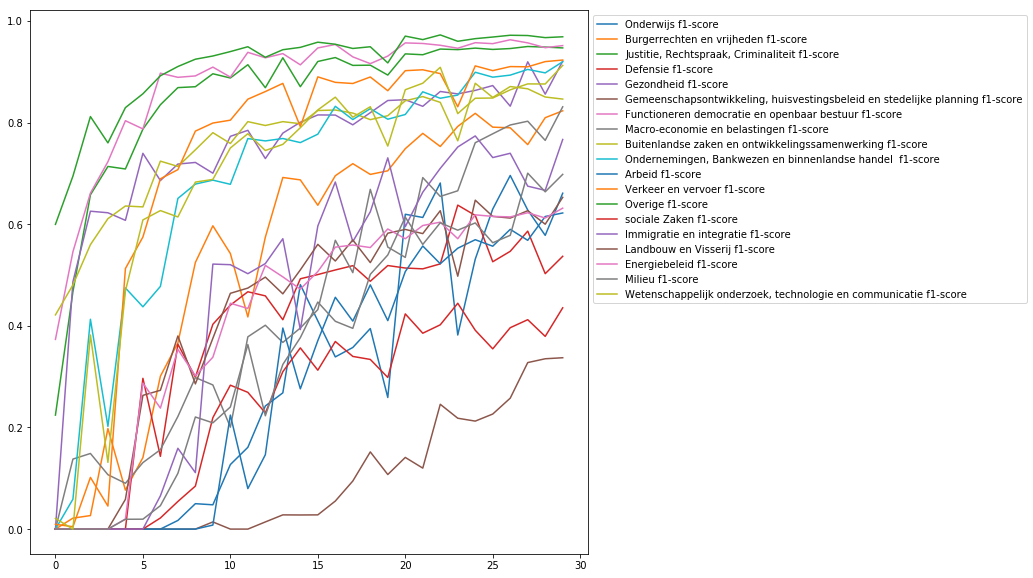

In [143]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,10))
for m in ['f1-score']:
    #for c in range(19):
    for l, c in zip(labels, range(19)):
        plt.plot(metrics_milticlass.get(m,c), label='{0} {1}'.format(l,m))

#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()

In [153]:
recall = {}
for m in ['recall']:
    for l, c in zip(labels, range(19)):
        #print(m, l)
        #print(metrics_milticlass.get(m, c)[-1])
        recall[l] = metrics_milticlass.get(m, c)[-1]
        
recall['total'] = sum(recall.values()) / len(recall.values() )

In [154]:
recall

{'Arbeid': 0.856,
 'Buitenlandse zaken en ontwikkelingssamenwerking': 0.9261744966442953,
 'Burgerrechten en vrijheden': 0.7397260273972602,
 'Defensie': 0.38636363636363635,
 'Energiebeleid': 0.48,
 'Functioneren democratie en openbaar bestuur': 0.9544401544401544,
 'Gemeenschapsontwikkeling, huisvestingsbeleid en stedelijke planning': 0.20567375886524822,
 'Gezondheid': 0.9435336976320583,
 'Immigratie en integratie': 0.7044334975369458,
 'Justitie, Rechtspraak, Criminaliteit': 0.908541846419327,
 'Landbouw en Visserij': 0.49375,
 'Macro-economie en belastingen': 0.7963446475195822,
 'Milieu': 0.8029556650246306,
 'Ondernemingen, Bankwezen en binnenlandse handel ': 0.894,
 'Onderwijs': 0.5065502183406113,
 'Overige': 0.9874415168677666,
 'Verkeer en vervoer': 0.8632075471698113,
 'Wetenschappelijk onderzoek, technologie en communicatie': 0.8528610354223434,
 'sociale Zaken': 0.823170731707317,
 'total': 0.7434299198605784}

In [171]:
VALIDATION_SIZE=200

model.fit(Xtrain[:-VALIDATION_SIZE], y_train[:-VALIDATION_SIZE], 
          epochs=2, verbose=True, validation_data=(Xtrain[-VALIDATION_SIZE:], y_train[-VALIDATION_SIZE:]))

Train on 11792 samples, validate on 200 samples
Epoch 1/2
11792/11792 [==============================] - 159s 13ms/sample - loss: 2.4494 - recall_0: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.9884 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/2
11792/11792 [==============================] - 158s 13ms/sample - loss: 1.9173 - recall_0: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.9532 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00


In [174]:
n = len(df)
recall = [0] * n
update_op_rec = [[]] * n

for k in range(n):
    recall[k], update_op_rec[k] = tf.metrics.recall(
        labels=tf.equal(y_test, k),
        predictions=tf.equal(y_pred, k)
    )

W0918 15:41:45.471902 140409137100544 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/metrics_impl.py:2201: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0918 15:41:45.473794 140409137100544 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/metrics_impl.py:2201: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [176]:
update_op_rec

[<tf.Tensor 'recall/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_1/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_2/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_3/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_4/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_5/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_6/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_7/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_8/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_9/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_10/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_11/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_12/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_13/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_14/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_15/update_op:0' shape=() dtype=float32>,
 <tf.Tensor 'recall_16/update_op:0' 

In [125]:
from sklearn.datasets import make_classification
x, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1, n_classes=3)

ValueError: n_classes * n_clusters_per_class must be smaller or equal 2 ** n_informative

In [123]:
y

array([0, 2, 1, 1, 2, 1, 0, 0, 2, 1, 0, 2, 2, 0, 1, 0, 2, 2, 2, 0, 1, 0,
       1, 2, 0, 1, 1, 1, 2, 1, 1, 0, 0, 0, 2, 2, 1, 2, 0, 2, 0, 1, 0, 2,
       1, 0, 0, 1, 0, 2, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1,
       0, 0, 1, 0, 0, 1, 2, 0, 2, 1, 1, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0,
       2, 1, 2, 0, 1, 1, 2, 0, 2, 2, 0, 0])

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, y_test, verbose=0)

In [87]:
y_pred = model.predict(Xtest, batch_size=64, verbose=1)

2999/2999 [==============================] - 14s 5ms/sample


In [88]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(Xtest)
print(classification_report(Y_test, y_pred))

ValueError: Mix type of y not allowed, got types {'continuous-multioutput', 'multiclass'}

In [24]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

In [90]:
loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, y_test, verbose=0)

In [96]:
f1_score
print('f1 score: %f' % (recall*100))

f1 score: 45.121706


In [89]:
loss, acc = model.evaluate(Xtest, y_test, verbose=True)
print('Test Accuracy: %f' % (acc*100))

2999/2999 [==============================] - 15s 5ms/sample - loss: 3.1040 - acc: 0.5025 - f1_m: 0.5171 - precision_m: 0.6099 - recall_m: 0.4512


ValueError: too many values to unpack (expected 2)

In [ ]:

# compile network

# fit network
model.fit(Xtrain, y_train, epochs=3, verbose=True)
# evaluate
loss, acc = model.evaluate(Xtest, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))


In [ ]:
# embeddings_index['man'] - embeddings_index['vrouw']


In [ ]:
embedding_matrix = np.zeros((N_FEATURES + 1, dimensions))
for i,word in enumerate(vectorizer.get_feature_names()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        